In [1]:
import json
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random
import torch
from os import path
from sklearn.model_selection import train_test_split
import random
import gc
import transformers
from tqdm import tqdm, trange
from typing import Callable, Dict, List, Tuple
from timeit import default_timer as timer
from transformers import EncoderDecoderModel, AutoTokenizer, PreTrainedTokenizer, BatchEncoding
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import nltk
import os
import json
# import nlpaug.augmenter.word as naw
# import nlpaug.flow as naf
# from nlpaug.util import Action
# from nlpaug.util.file.download import DownloadUtil

/home/daniele/.miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def uniform(el):
    """
    Handles the values for multi-value attributes, splitting to list if necessary
    If the input is a list or transformed to a list, values are sorted

    Args:
        el (str or list): The attribute value

    Returns:
        str or list: The attribute value sorted if it is a list, the attribute value otherwise
    """
    if el == el:  # NaN is different from NaN, np.isnan and pd.isna don't work
        if '|' in el:
            el = sorted(el.split('|'))
        elif isinstance(el, list):
            el = sorted(el)
    return el


def create_df_annotations(path: str, dataset: str):
    """
    Load the dataset + create and save to file a dataframe with the annotations of the arguments.

    Args:
        path (str): path of the folder containing the JSON files
        dataset (str): One of [vat, tp, ecj]
    """
    temp = []

    files = os.listdir(path)
    files.sort()

    language = files[0].split('_')[0]

    for filename in files:
        if not filename.endswith('.json'):
            print(f"Skipping '{filename}'")
        else:
            print(f"Loading '{filename}'")
            with open(os.path.join(path, filename), 'r', encoding='utf8') as f:
                data = json.load(f)
                annotations = data["annotations"]
                last_full_chain_id = None
                last_text = None

                for annotation in annotations:
                    if annotation["name"] != 'conc' and annotation["name"] != 'prem':
                        continue # Ignore intro, nreg, judoff, ...
                    #document = annotation["document"]
                    document = data["document"]["name"]
                    name = annotation["name"]
                    _id = annotation["_id"]
                    argument_chain_id = _id[0]
                    full_chain_id = f'{document}_{argument_chain_id}'
                    last_full_chain_id = full_chain_id
                    incremental_num = _id[1:]
                    text = data["document"]["plainText"][int(annotation["start"]):int(annotation["end"])]
                    last_text = text
                    # attribute extraction, NaN if that attribute is not present
                    T = uniform(annotation["attributes"].get("T", np.nan))
                    SUP = uniform(annotation["attributes"].get("SUP", np.nan))
                    SFF = uniform(annotation["attributes"].get("SFF", np.nan))
                    ATT = uniform(annotation["attributes"].get("ATT", np.nan))
                    INH = uniform(annotation["attributes"].get("INH", np.nan))
                    REPH = uniform(annotation["attributes"].get("REPH", np.nan))
                    S = uniform(annotation["attributes"].get("S", np.nan))

                    text = text.replace('\n','').lstrip('‘’\'\n0123456789.-–…;;) ').rstrip('‘’\'\n.;; ')

                    temp.append([
                        document,
                        name,
                        _id,
                        argument_chain_id,
                        incremental_num,
                        text,
                        T,
                        SUP,
                        SFF,
                        ATT,
                        INH,
                        REPH,
                        S,
                        full_chain_id,
                        last_text if last_full_chain_id == full_chain_id else None,
                    ])
    # df creation
    df = pd.DataFrame(temp,
                      columns=['Document', 'Name', 'Id', 'Chain', 'Num', 'Text', 'Type', 'SUP', 'SFF',
                               'ATT', 'INH', 'REPH', 'Scheme', 'FullChainID', 'Previous'])
    
    df.to_pickle("./Dataframes/arg_annotations_" + language + '_' + dataset + ".pkl")
    df.to_csv("./Dataframes/arg_annotations_" + language + '_' + dataset + ".csv")


create_df_annotations('Data/Dataset/VAT_ITA', 'vat')


Loading 'italian_1000.json'
Skipping 'italian_1000.json:Zone.Identifier'
Loading 'italian_1001.json'
Skipping 'italian_1001.json:Zone.Identifier'
Loading 'italian_1002.json'
Skipping 'italian_1002.json:Zone.Identifier'
Loading 'italian_1003.json'
Skipping 'italian_1003.json:Zone.Identifier'
Loading 'italian_1004.json'
Skipping 'italian_1004.json:Zone.Identifier'
Loading 'italian_1005.json'
Skipping 'italian_1005.json:Zone.Identifier'
Loading 'italian_1006.json'
Skipping 'italian_1006.json:Zone.Identifier'
Loading 'italian_1007.json'
Skipping 'italian_1007.json:Zone.Identifier'
Loading 'italian_1008.json'
Skipping 'italian_1008.json:Zone.Identifier'
Loading 'italian_1009.json'
Skipping 'italian_1009.json:Zone.Identifier'
Loading 'italian_1010.json'
Skipping 'italian_1010.json:Zone.Identifier'
Loading 'italian_1011.json'
Skipping 'italian_1011.json:Zone.Identifier'
Loading 'italian_1012.json'
Skipping 'italian_1012.json:Zone.Identifier'
Loading 'italian_1013.json'
Skipping 'italian_1013.

In [3]:
df = pd.read_pickle("Dataframes/arg_annotations_italian_vat.pkl")

In [4]:
df.describe()

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
top,2016_202_VAT_OPAM_2_1_PS_AN,prem,A2,A,2,,F,A2,A7,A8,A10,A1,Rule,2016_202_VAT_OPAM_2_1_PS_AN_A,
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [5]:
df.head(10)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
5,2013_40_VAT_OPAM_2_REM_MB_PS_AN,conc,A6,A,6,"Poiché ciò non è avvenuto, risulta applicabile...",NaN,"[A1, A2, A3]","[A4, A5]",NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"\n Poiché ciò non è avvenuto, risulta appl..."
6,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A1,A,1,Secondo condivisa e costante giurisprudenza (C...,L,NaN,NaN,NaN,NaN,NaN,Rule,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Secondo condivisa e costante giurisprudenza (C...
7,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A2,A,2,"Tuttavia, nel caso qui in esame, la Comm/ne no...",L,"[A3, A4]",NaN,NaN,NaN,NaN,Itpr,2018_847_VAT_OP_2_-1_MB_AF_AN_A,"Tuttavia, nel caso qui in esame, la Comm/ne no..."
8,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A3,A,3,A tal proposito si ricorda che la Corte cost. ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,A tal proposito si ricorda che la Corte cost. ...
9,2018_847_VAT_OP_2_-1_MB_AF_AN,prem,A4,A,4,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...,L,NaN,NaN,NaN,NaN,NaN,Prec,2018_847_VAT_OP_2_-1_MB_AF_AN_A,Inoltre (Cass. 2.9.2013 n. 20064) “qualora la ...


Example of row with multiple attribute values:

In [6]:
df[df["FullChainID"] == "2021_2717_VAT_OPAM_2_1_FG_PS_AN_A"]

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
3213,2021_2717_VAT_OPAM_2_1_FG_PS_AN,conc,A1,A,1,Passando all'esame del motivo di appello con c...,NaN,A13,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Passando all'esame del motivo di appello con c...
3214,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A2,A,2,"Sul punto, come è noto, giova ricordare che la...",L,NaN,NaN,NaN,NaN,NaN,Princ,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Sul punto, come è noto, giova ricordare che la..."
3215,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A3,A,3,"Con riguardo al primo profilo, dall'esame degl...","[F, L]",NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Con riguardo al primo profilo, dall'esame degl..."
3216,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A4,A,4,Per quanto riguarda il secondo profilo (come r...,F,"[A5, A6]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda il secondo profilo (come r...
3217,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A5,A,5,"Infatti, secondo la corretta interpretazione d...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Infatti, secondo la corretta interpretazione d..."
3218,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A6,A,6,"Ed ancora, le suddette disposizioni vanno inte...",L,NaN,NaN,NaN,NaN,NaN,Prec,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Ed ancora, le suddette disposizioni vanno inte..."
3219,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A7,A,7,"Pertanto, tutti i motivi di appello dell'Uffic...",F,"[A2, A3, A4]",NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Pertanto, tutti i motivi di appello dell'Uffic..."
3220,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A8,A,8,"Inoltre, nel caso specifico va sottolineato il...",F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,"Inoltre, nel caso specifico va sottolineato il..."
3221,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A9,A,9,Per quanto riguarda gli ulteriori motivi con i...,F,NaN,NaN,NaN,NaN,NaN,NaN,2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,Per quanto riguarda gli ulteriori motivi con i...
3222,2021_2717_VAT_OPAM_2_1_FG_PS_AN,prem,A10,A,10,In proposito giova ricordare che l’inesistenza...,"[F, L]",NaN,NaN,NaN,NaN,NaN,"[Prec, Rule]",2021_2717_VAT_OPAM_2_1_FG_PS_AN_A,In proposito giova ricordare che l’inesistenza...


Check whether there are any null values for ARGUMENT CLASSIFICATION(AC) task (Name column), and if it's the case then drop them:

In [7]:
df_ac = df[~(df['Name'].isnull())].reset_index(drop=True)
df_ac['Name'].unique()

array(['prem', 'conc'], dtype=object)

Check whether there are any null values for TYPE CLASSIFICATION(TC) task (Type column), and if it's the case then drop them

In [8]:
df_tc = df_ac[~(df_ac['Type'].isnull())].reset_index(drop=True) 
df_tc.describe()
df_tc['Type'].drop_duplicates()


0          F
1          L
13    [F, L]
Name: Type, dtype: object

Check whether there are any null values for SCHEME CLASSIFICATION(SC) task (Scheme column), and if it's the case then drop them

In [9]:
df_sc = df_tc[~(df_tc['Scheme'].isnull())].reset_index(drop=True) 
#print(df_sc.describe())
df_sc['Scheme'].drop_duplicates()

0                      Rule
1                      Itpr
4                      Prec
15             [Itpr, Prec]
21                      Aut
               ...         
1223    [Class, Itpr, Rule]
1240           [Acon, Itpr]
1241          [Class, Tele]
1276     [Prec, Rule, Syst]
1282     [Aut, Itpr, Princ]
Name: Scheme, Length: 63, dtype: object

In [10]:
df_ac.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,3311,3311,3311,3311,3311,3311,2910,1088,82,66,25,89,1314,3311,3311
unique,225,2,264,10,98,3163,3,428,48,32,19,31,63,367,3186
freq,79,2910,221,2348,365,12,1572,54,6,8,3,29,349,79,12


In [11]:
df_tc.describe().drop('top',axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,2910,2910,2910,2910,2910,2910,2910,691,42,66,25,20,1314,2910,2910
unique,225,1,255,10,95,2797,3,299,28,32,19,16,63,367,2812
freq,78,2910,214,2094,347,11,1572,30,4,8,3,2,349,78,11


In [12]:
df_sc.describe().drop('top', axis=0)

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
count,1314,1314,1314,1314,1314,1314,1314,272,14,9,14,3,1314,1314,1314
unique,203,1,164,10,62,1256,3,129,11,7,13,3,63,309,1260
freq,41,1314,103,944,174,3,1000,15,2,2,2,1,349,41,3


# Type classification multi-label-binarizer

In [13]:
df_tc.loc[13,'Type']

['F', 'L']

In [14]:
#need to extract the values from the list, in a way to pass it to the multilabelbinarizer
for i in range(len(df_tc)):
    x = df_tc.loc[i,'Type']
    if type(x) == list:
        df_tc.loc[i,'Type'] = ",".join([x[0],x[1]])
         

In [15]:
df_tc.loc[13,'Type']

'F,L'

In [16]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb_result = mlb.fit_transform([str(df_tc.loc[i,'Type']).split(',') for i in range(len(df_tc))])
df_tc_final = pd.concat([df_tc,pd.DataFrame(mlb_result,columns=list(mlb.classes_))],axis=1)
df_tc_final

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous,F,L
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con...",1,0
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'...",0,1
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...,0,1
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...,1,0
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...,0,1
2906,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...,0,1
2907,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f...",0,1
2908,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...,0,1


In [17]:
df_tc_labels = df_tc_final[['F','L']]
df_tc_labels

,F,L
0,1,0
1,0,1
2,0,1
3,1,0
4,1,0
...,...,...
2905,0,1
2906,0,1
2907,0,1
2908,0,1


# Data analysis

<Axes: >

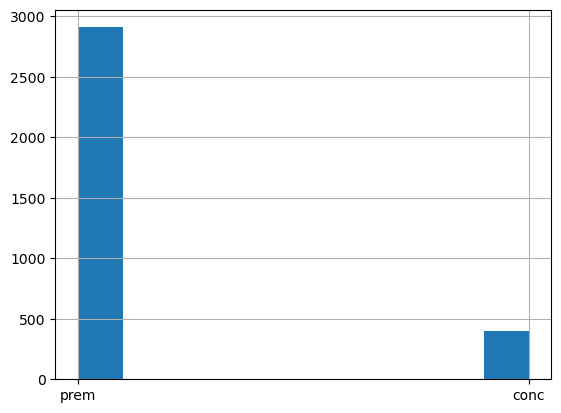

In [18]:
df_ac['Name'].hist()

In [19]:
print(f"There are {len(df_ac[df_ac['Name'] == 'prem'])} premises and {len(df_ac[df_ac['Name'] == 'conc'])} conclusions")

There are 2910 premises and 401 conclusions


<BarContainer object of 2 artists>

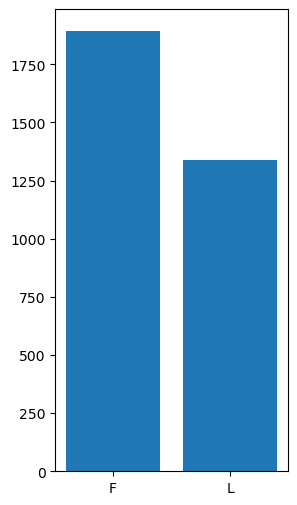

In [20]:
values = df_tc_labels.sum().sort_values(ascending=False)
y = np.array(values)
x = np.array(values.index)

plt.figure(figsize=(3,6))
plt.bar(x, height=y)

In [21]:
df_tc

,Document,Name,Id,Chain,Num,Text,Type,SUP,SFF,ATT,INH,REPH,Scheme,FullChainID,Previous
0,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A1,A,1,"In via preliminare, il Collegio prende in cons...",F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"In via preliminare, il Collegio prende in con..."
1,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A2,A,2,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'o...",L,NaN,NaN,NaN,NaN,NaN,Rule,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,"Ai sensi dell'art. 14 del d.lgs.546/92, se l'..."
2,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A3,A,3,Se il ricorso non è stato proposto da o nei...,L,NaN,NaN,NaN,NaN,NaN,Itpr,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Se il ricorso non è stato\n proposto da o ...
3,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A4,A,4,Nel caso di specie solo la ILDS ha presentato ...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,Nel caso di specie solo la ILDS ha presentato...
4,2013_40_VAT_OPAM_2_REM_MB_PS_AN,prem,A5,A,5,come espressamente richiesto nel ricorso in...,F,NaN,NaN,NaN,NaN,NaN,NaN,2013_40_VAT_OPAM_2_REM_MB_PS_AN_A,come\n espressamente richiesto nel ricorso...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2905,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C15,C,15,Sotto questo profilo i Compro Oro sono sottopo...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Sotto questo profilo i Compro Oro sono sottopo...
2906,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C16,C,16,Tale comunicazione ha luogo quando i destinata...,L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,Tale comunicazione ha luogo quando i destinata...
2907,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C17,C,17,"Il Ministro dell'interno, con decreto del 17 f...",L,NaN,NaN,NaN,NaN,NaN,Rule,2021_6075_VAT_OPAM_2_1_PS_AN_C,"Il Ministro dell'interno, con decreto del 17 f..."
2908,2021_6075_VAT_OPAM_2_1_PS_AN,prem,C18,C,18,Tra i soggetti destinatari del decreto sono ri...,L,NaN,NaN,NaN,NaN,NaN,"[Class, Rule]",2021_6075_VAT_OPAM_2_1_PS_AN_C,Tra i soggetti destinatari del decreto sono ri...


In [22]:
# Fix the random state for reproducibility
SEED = 27

def fix_seed(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_seed(SEED)

## Train-Val-Test dataset splitting

In [23]:
idx_train, idx_test = train_test_split(df['FullChainID'].unique(),
                                     random_state=SEED,
                                     test_size=0.1)
idx_train, idx_val = train_test_split(idx_train,
                                     random_state=SEED,
                                     test_size=idx_test.shape[0])
df_train = df[df['FullChainID'].isin(idx_train)]
df_test = df[df['FullChainID'].isin(idx_test)]
df_val = df[df['FullChainID'].isin(idx_val)]
print('Number of training samples: {}'.format(df_train.shape[0]))
print('Number of test samples: {}'.format(df_test.shape[0]))
print('Number of validation examples: {}'.format(df_val.shape[0]))

Number of training samples: 2516
Number of test samples: 391
Number of validation examples: 404


#### Save and load results
The results folder will contain the notebook, metrics and outputs for each seed.

In [24]:
results_folder = "results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

def results_to_csv(df_results, seed):
    '''
    Args:
        df_results: DataFrame with the all the scores
        seed: the used seed
    '''
    csv_path = f"{results_folder}/{seed}.csv"
    df_results.to_csv(path_or_buf=csv_path)

In [25]:
def results_from_csv(seed):
    '''
    Args:
        seed: the wanted seed
    '''
    file_path = f"results/{seed}.csv"
    df_results = pd.read_csv(file_path)

    return df_results

#### PyTorch dataset

In [26]:
class CreateDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

## Model definition

In [27]:
def encode(tokenizer, df, labels_emo, labels_tri):
  '''
  Encodes the dataset according to the BERT specifications.
  The method encodes the data in the following way:
    [CLS] previous [SEP] current [SEP]
    where -previous- is the previous (if any) sentence in the same argumentation chain
    and -current- is the current sentence
  '''
  encodings = tokenizer(list(df['Previous']),
                        list(df['Text']),
                          padding=True,
                          truncation=True,
                          max_length = 512,
                          )

  input_ids, input_attention_mask = encodings['input_ids'], encodings['attention_mask']
  print(f"input shape: {np.shape(input_ids)}")
  encodings.update({'labels_emo' : torch.LongTensor(labels_emo.values)})
  labels_tri = np.expand_dims(labels_tri.values, axis=1)
  encodings.update({'labels_tri' : torch.FloatTensor(labels_tri)})
  encodings.pop('token_type_ids')
  return encodings

In [28]:
from transformers import DistilBertModel, BertModel
import torch.nn as nn

class CustomBERTModel(nn.Module):

      def __init__(self,checkpoint, num_labels_emo, num_labels_tri):
            super(CustomBERTModel, self).__init__()
            # TODO

      def forward(self, input_ids, attention_mask):
            return # TODO

In [29]:
def getModel(model_checkpoint, num_labels_emo, num_labels_tri):
  '''
  Creates and return an instance of the desired model with the correct tokenizer.
  '''
  model = CustomBERTModel(model_checkpoint, num_labels_emo, num_labels_tri)
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False)

  return model, tokenizer

#### Train

In [30]:
# Train one epoch
def train(model: torch.nn.Module,
          train_loader:torch.utils.data.DataLoader,
          device: torch.device,
          optimizer: torch.optim,
          criterion: list,
          epoch: int,
          trig_weight: float) -> float:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.
        optimizer: the optimizer to use to train the model.
        criterion: criterions used to calculate loss.
        epoch: the number of the current epoch.
        trig_weight: trigger loss multiplier.

    Returns:
        the cross entropy Loss value on the training data.
    """

    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)
    loss_score = []
    loop = tqdm(train_loader)
    #set training mode
    model.train()
    for idx_batch, batch in enumerate(loop):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels_emo = batch['labels_emo'].to(device)
        labels_tri = batch['labels_tri'].to(device)
        #print(f"target-size: {labels.shape}")
        logits_emo, logits_tri = model(input_ids,
                                        attention_mask=attention_mask,
                                    )
        #print(f"logits-size: {logits.shape}")
        loss_emo = criterion[0](logits_emo, labels_emo)
        loss_tri = criterion[1](logits_tri, labels_tri)
        loss = loss_emo + trig_weight*loss_tri
        loss_score.append(loss.item())
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())

    loss_train = np.mean(loss_score)
    return loss_train

# Validate one epoch
def validate(model: torch.nn.Module,
             criterion: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             device: torch.device,
             trig_weight: float) -> float:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        criterion: criterions used to calculate loss.
        data_loader: the data loader containing the validation data.
        device: the device to use to evaluate the model.
        trig_weight: trigger loss multiplier.

    Returns:
        the loss value on the validation data.
    """
    loss_score = []
    #set evaluation mode
    model = model.eval()
    with torch.no_grad():
        for idx_batch, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_emo = batch['labels_emo'].to(device)
            labels_tri = batch['labels_tri'].to(device)
            logits_emo, logits_tri = model(input_ids,
                                            attention_mask=attention_mask,
                                        )
            loss_emo = criterion[0](logits_emo, labels_emo)
            loss_tri = criterion[1](logits_tri, labels_tri)
            loss = loss_emo + trig_weight*loss_tri
            loss_score.append(loss.item())
    loss_val = np.mean(loss_score)
    return loss_val

In [31]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim,
                  criterion: torch.nn.Module,
                  model: torch.nn.Module,
                  loader_train: torch.utils.data.DataLoader,
                  loader_val : torch.utils.data.DataLoader = None,
                  model_dir = "models",
                  trig_weight = 1.0,
                  verbose: bool=True) -> Dict:
    """Executes the training loop.

        Args:
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            criterion: criterions used to calculate loss.
            model: the model to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            model_dir: checkpoints folder.
            trig_weight: trigger loss multiplier.
            verbose: if true print the value of loss.

        Returns:
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the validation loss for each epoch.
            the time of execution in seconds for the entire loop.
    """
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    loop_start = timer()
    train_losses_values = []
    val_losses_values = []

    best_epoch = 1

    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train = train(model, loader_train, device,
                                           optimizer, criterion, epoch, trig_weight=trig_weight)
        if(loader_val != None):
          loss_val = validate(model, criterion, loader_val, device, trig_weight=trig_weight)
        else:
          loss_val = 0
        time_end = timer()
        train_losses_values.append(loss_train)
        val_losses_values.append(loss_val)

        torch.save(model.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))
        best_epoch = np.argmin(val_losses_values)+1

        if verbose:
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')

        if epoch >= 2:
          if loss_val > val_losses_values[-2]:
            if verbose:
              print("Early Stopping. Best epoch: {}".format(best_epoch))
            break

    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}')

    model.load_state_dict(torch.load(os.path.join(model_dir, 'epoch-{}.pt'.format(best_epoch))))

    return {'train_loss_values': train_losses_values,
            'val_loss_values' : val_losses_values,
            'time': time_loop}

In [32]:
from torch.utils.data import WeightedRandomSampler

def execute(lr: float,
            num_epochs: int,
            batch_size: int,
            criterion: torch.nn.Module,
            num_labels_emo: int,
            num_labels_tri: int,
            data: pd.DataFrame,
            data_labels_emo: pd.DataFrame,
            data_labels_tri: pd.DataFrame,
            val_df: pd.DataFrame,
            val_labels_emo: pd.DataFrame,
            val_labels_tri: pd.DataFrame,
            model_name="",
            model=None,
            tokenizer=None,
            freeze_embeddings=False,
            weighted_sampling=False,
            trig_weight=1.0
            ) ->Tuple[torch.nn.Module, any]:
    """Gets the model, does the encodings of the training and validation data using the
        tokenizer, and then executes the training loop.

    Args:
        lr: the learning rate.
        num_epochs: the number of epochs.
        batch_size: the batch size.
        criterion: criterions used to calculate loss.
        num_labels_emo: number of emotion labels.
        num_labels_tri: number of trigger labels.
        data: training-val dataframe.
        data_labels_emo: training emotion labels dataframe.
        data_labels_tri: training trigger labels dataframe.
        val_df: validation dataframe.
        data_labels_emo: validation emotion labels dataframe.
        data_labels_tri: validation trigger labels dataframe.
        model_name: model's checkpoint name.
        model: the network to train (optional).
        tokenizer: tokenizer for the given model (if provided).
        freeze_embeddings: if True, the gradient in the embeddingl layers of BERT are ignored.
        weighted_sampling: if True, use a Weighted Sampler in the training data loader.
        trig_weight: trigger loss multiplier.
    """

    #train on full data
    #get the model and the tokenizer, freeze the embedding layers of Bert if requested
    if not model_name == "":
      model, tokenizer = getModel(model_name, num_labels_emo, num_labels_tri)

      if freeze_embeddings:
         for param in model.bert.embeddings.parameters():
            param.requires_grad = False
    #Start encodings
    train_encodings = encode(tokenizer, data, data_labels_emo, data_labels_tri)
    val_encodings = encode(tokenizer, val_df, val_labels_emo, val_labels_tri)
    print(f'ENCODING COMPLETE.')

    #create training dataset
    train_dataset = CreateDataset(train_encodings)

    # create weighted sampler to balance the dataset, based on the trigger column
    if weighted_sampling:
        class_counts = data_labels_tri.value_counts()
        class_weights = 1/class_counts
        sample_weights = [1/class_counts[i] for i in data_labels_tri.values]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(data_labels_tri), replacement=True)
        #create training dataloader
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            sampler = sampler
                                            )
    # otherwise, create the standard dataloader
    else:
        data_loader_train = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=batch_size,
                                            shuffle = True
                                            )

    #create validation dataset
    val_dataset = CreateDataset(val_encodings)
    #create validation dataloader
    data_loader_val = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=batch_size,
                                          shuffle = False
                                          )
    #Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1.5e-2)
    print(f'STARTING TRAINING with complete data:')
    # select the correct checkpoints folder
    model_dir = 'model_data'
    statistics = training_loop(num_epochs, optimizer, criterion, model,
                              data_loader_train, data_loader_val, model_dir=model_dir, trig_weight=trig_weight)
    print(f'TRAINING COMPLETE.')

    return model, tokenizer, statistics

In [33]:

#parameters
lr = 5e-5
batch_size = 32
epochs = 8
criterion = [torch.nn.CrossEntropyLoss(), torch.nn.BCELoss()]

# specific model's configuration
weighted_sampling=False
trig_weight=3.0

In [34]:
FAST_AND_SMALL = False # only for debugging

num_labels_emo = len(df_train['labemo'].unique())
num_labels_tri = len(df_train['trigger'].unique())

if FAST_AND_SMALL:
    df_train = df_train[:2000]
    df_val = df_val[:1000]

df_train_labels_emo = df_train['labemo']
df_train_labels_tri = df_train['trigger']
df_val_labels_emo = df_val['labemo']
df_val_labels_tri = df_val['trigger']

KeyError: 'labemo'

In [ ]:
model_checkpoint='dlicari/Italian-Legal-BERT'
model_full, tokenizer_full, statistics_full = execute(lr, epochs, batch_size, criterion, num_labels_emo, num_labels_tri, df_train, df_train_labels_emo, df_train_labels_tri, df_val, df_val_labels_emo, df_val_labels_tri, model_name=model_checkpoint, weighted_sampling=weighted_sampling, trig_weight=trig_weight)

#### Evaluation

In [ ]:
def evaluate(model, data_loader, trigger_th=0.5, calculate_original=False):
    '''
    Args:
      model: trained model.
      data_loader: source of evaluation data.
      trigger_th: trigger threshold for True trigger predictions.

    Returns:
      pred_emo: predicted emotions.
      pred_tri: predicted thresholded triggers.
      pred_tri_orig: raw model's trigger predictions.
    '''
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.eval()
    model.to(device)
    pred_emo = []
    pred_tri = []
    pred_tri_orig = []
    with torch.no_grad():
        for step_num, batch in tqdm(enumerate(data_loader)):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels_emo = batch['labels_emo'].to(device)
            labels_tri = batch['labels_tri'].to(device)
            output = model(input_ids, attention_mask=attention_mask, )
            p_emo, p_tri = output
            p_emo = p_emo.cpu().detach().numpy()
            p_tri = p_tri.cpu().detach().numpy().reshape(-1)
            p_tri_filt = np.where(p_tri > trigger_th, 1, 0).astype(float)
            pred_emo.append(np.argmax(p_emo,axis=-1))
            pred_tri.append(p_tri_filt)
            pred_tri_orig.append(p_tri)
    pred_emo = np.concatenate(pred_emo)
    pred_tri = np.concatenate(pred_tri)
    pred_tri_orig = np.concatenate(pred_tri_orig)

    return pred_emo, pred_tri, pred_tri_orig